## Importing Libraries

In [1]:
import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from itertools import groupby
import matplotlib.pyplot as plt

import joblib
import pickle

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

folder_path = "../data/open-problems-single-cell-perturbations/"

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression

reg_dict = {"LinearRegression": LinearRegression(),
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            "Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            "Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            "Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            "Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(),
            "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
            "GaussianProcessRegressor": GaussianProcessRegressor(),
            "SGDRegressor": SGDRegressor(),
            "MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            "PLSRegression": PLSRegression(n_components=10),
            "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=0),
            "RANSACRegressor": RANSACRegressor(random_state=0),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
            "BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            "VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            "StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            "ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
                    }


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Necessary Files 

In [2]:
de_train = pd.read_parquet(f'{folder_path}/de_train.parquet')
id_map = pd.read_csv(f'{folder_path}/id_map.csv', index_col='id')
genes = de_train.columns[5:]

In [3]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [4]:
id_map

,cell_type,sm_name
id,,
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,B cells,ABT-199 (GDC-0199)
2,B cells,ABT737
3,B cells,AMD-070 (hydrochloride)
4,B cells,AT 7867
...,...,...
250,Myeloid cells,Vandetanib
251,Myeloid cells,Vanoxerine
252,Myeloid cells,Vardenafil


## Function

In [5]:
def add_lincID_SMILES_to_IDMap(de_train, id_map):
    sm_lincs_id = de_train.set_index('sm_name')["sm_lincs_id"].to_dict()
    sm_name_to_smiles = de_train.set_index('sm_name')['SMILES'].to_dict()
    id_map['sm_lincs_id'] = id_map['sm_name'].map(sm_lincs_id)
    id_map['SMILES'] = id_map['sm_name'].map(sm_name_to_smiles)
    
    return id_map

add_lincID_SMILES_to_IDMap(de_train, id_map)

,cell_type,sm_name,sm_lincs_id,SMILES
id,,,,
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,LSM-47134,Cc1nc2c(-c3cnc(N)nc3)nc(N3CCOCC3)nc2n1C(C)C
1,B cells,ABT-199 (GDC-0199),LSM-45468,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
2,B cells,ABT737,LSM-1180,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...
3,B cells,AMD-070 (hydrochloride),LSM-45591,NCCCCN(Cc1nc2ccccc2[nH]1)[C@H]1CCCc2cccnc21
4,B cells,AT 7867,LSM-1155,Clc1ccc(C2(c3ccc(-c4cn[nH]c4)cc3)CCNCC2)cc1
...,...,...,...,...
250,Myeloid cells,Vandetanib,LSM-1199,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
251,Myeloid cells,Vanoxerine,LSM-2703,Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1
252,Myeloid cells,Vardenafil,LSM-2292,CCCc1nc(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(CC...


In [6]:
def calculate_mae_and_mrrmse(y_true, y_pred, scaler=None):
    if scaler:
        y_true = scaler.inverse_transform(y_true)
        y_pred = scaler.inverse_transform(y_pred)

        # Calculate Mean Rowwise Root Mean Squared Error (MRRMSE)
        rowwise_rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=1))
        mrrmse_score = np.mean(rowwise_rmse)
    else:
        # Calculate Mean Rowwise Root Mean Squared Error (MRRMSE)
        rowwise_rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=1))
        mrrmse_score = np.mean(rowwise_rmse)
    
    # Print the results
    print(f"MRRMSE Score: {mrrmse_score}")

## Data Preprocessing

In [7]:
kf = KFold(n_splits=6, shuffle=True, random_state=None)

# Create k-fold columns
for fold, (train_index, test_index) in enumerate(kf.split(de_train)):
    de_train.loc[test_index, 'kfold'] = fold
    
    
    # plt.figure(figsize=(10, 6))
    # for fold, (_, test_index) in enumerate(kf.split(de_train)):
    #     plt.scatter(test_index, [fold] * len(test_index), label=f'Fold {fold}')

    # plt.title('KFold Cross-Validation')
    # plt.xlabel('Data Index')
    # plt.ylabel('Fold Number')
    # plt.legend()
    # plt.show()

de_train['kfold'] = de_train['kfold'].astype(int)

# Reindex DataFrame to put 'kfold' as the first column
cols = ['kfold'] + [col for col in de_train if col != 'kfold']
de_train = de_train[cols]

de_train

,kfold,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,2,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,4,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,1,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,5,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,0,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,2,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,1,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,1,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


## Train Data

In [15]:
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_regression
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """MAPE"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_size = 0.3  # 分割比率
N_trials = 10  # 試行回数

# 回帰対象のデータを生成
x, y = make_regression(random_state=12, 
                       n_samples=100, 
                       n_features=10,
                       n_informative=4,
                       noise=10.0,
                       bias=0.0)

mape_dict = {reg_name:[] for reg_name in reg_dict.keys()}  # 精度の格納庫

for i in range(N_trials):
    print(f"Trial {i+1}")
    random_state = random.randint(0, 1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    for reg_name, reg in reg_dict.items():
        reg.fit(x_train,y_train)
        y_pred = reg.predict(x_test)
        mape = mean_absolute_percentage_error(y_test, y_pred)  # MAPEを算出
        mape_dict[reg_name].append(mape)  # 格納

# MAPEの平均値でソート
mape_dict_sorted = {key: value for key, value in reversed(sorted(mape_dict.items(), key=lambda x:np.mean(x[1])))}


Trial 1


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'au

Trial 2


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'

Trial 3


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'au

Trial 4


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'

Trial 5


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'au

Trial 6


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'

Trial 7


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'au

Trial 8


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'au

Trial 9


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'

Trial 10


/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/shotomorisaki/Engineering/Single-Cell-Perturbations/env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'au

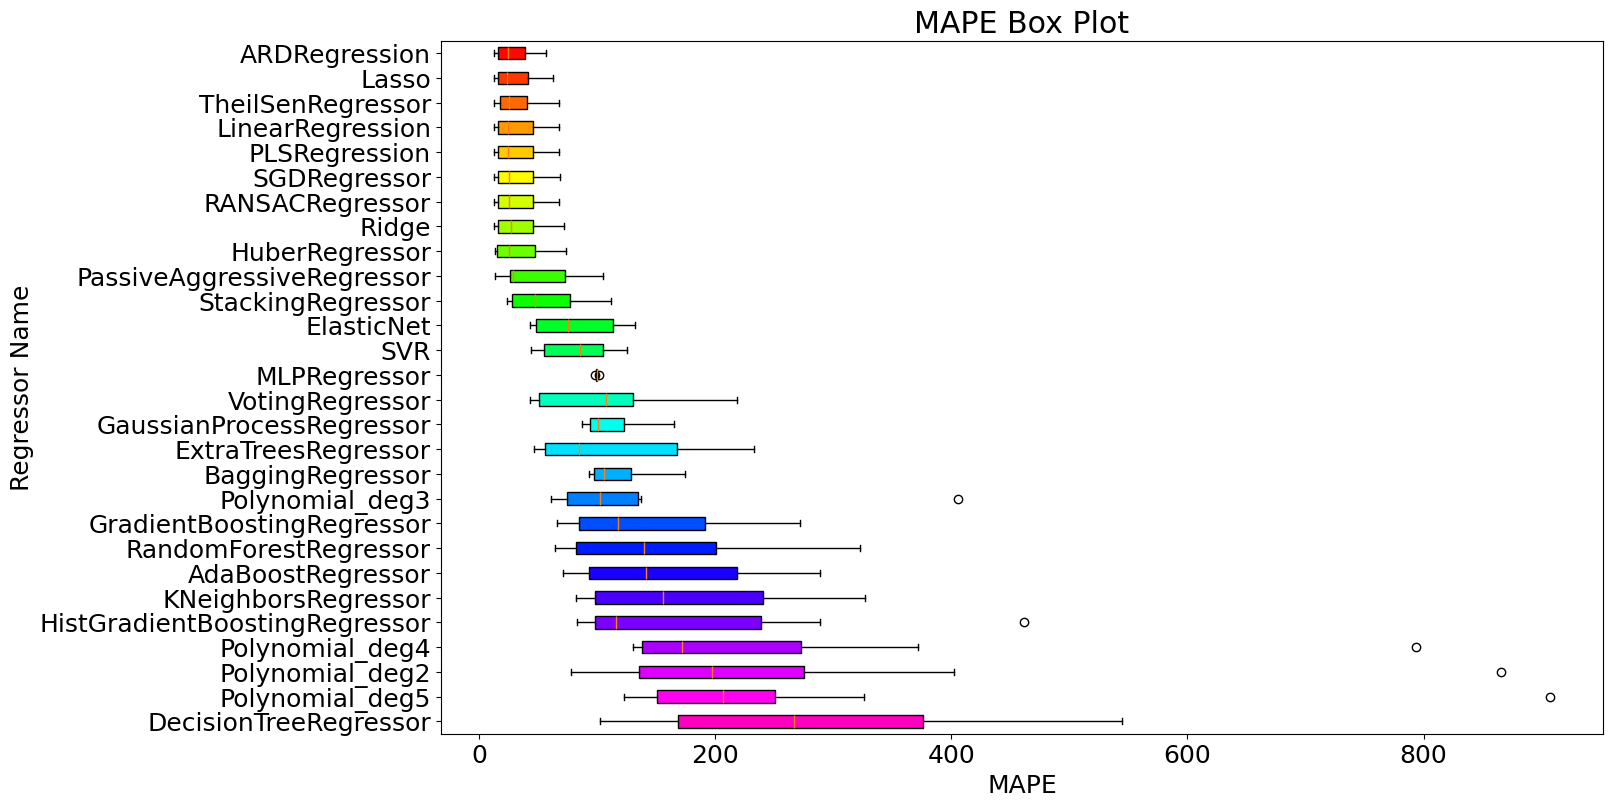

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.rcParams["font.size"] = 18  # フォントサイズを大きくする
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=len(mape_dict)), cmap=plt.get_cmap('gist_rainbow_r'))

plt.figure(figsize=(15,9))
box=plt.boxplot(mape_dict_sorted.values(), vert=False, patch_artist=True,labels=mape_dict_sorted.keys())
for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(scalarMap.to_rgba(i))
plt.title("MAPE Box Plot")
plt.xlabel("MAPE")
plt.ylabel("Regressor Name")
plt.show()


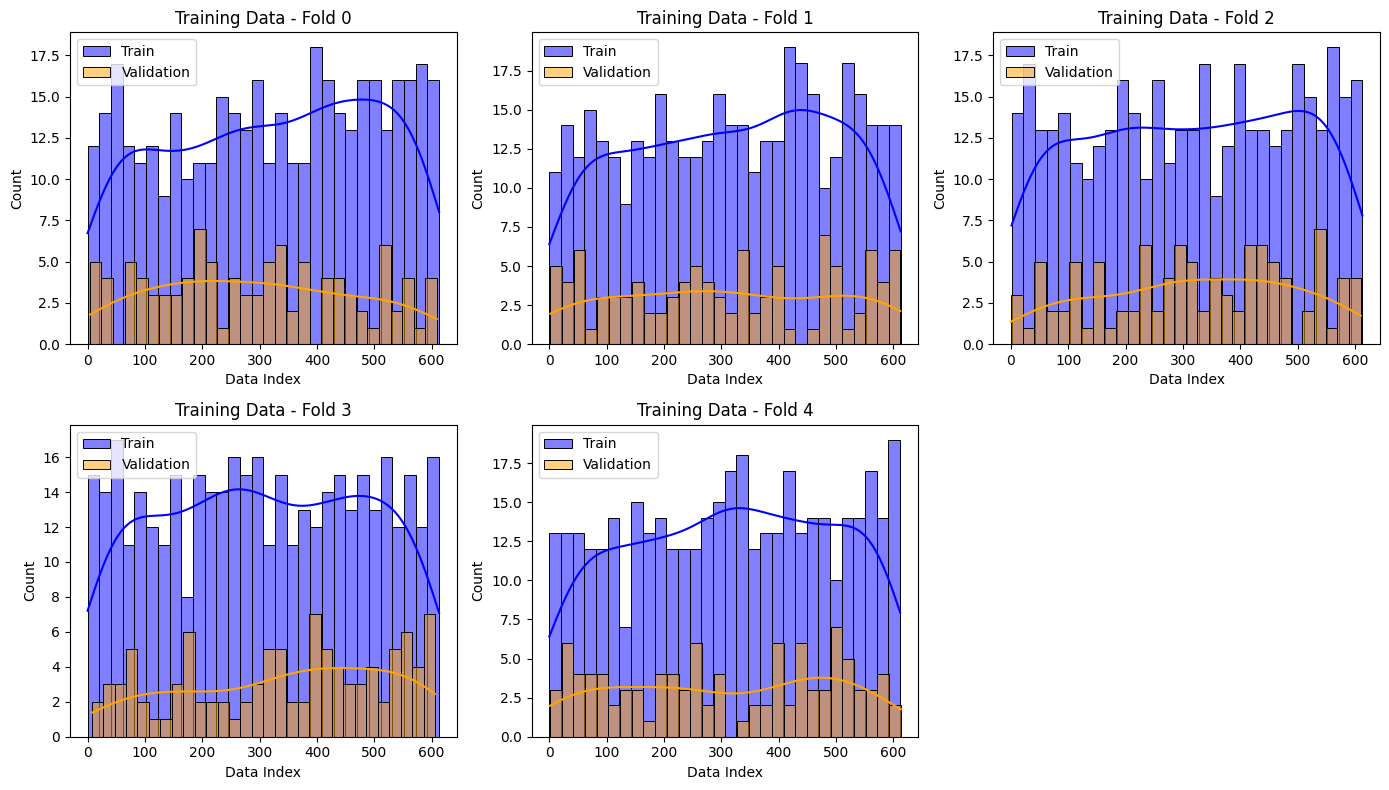

In [8]:
test_data = de_train[de_train["kfold"]==5].sample(frac=1, random_state=6174)
train_data = de_train[de_train["kfold"]!=5].sample(frac=1, random_state=6174)
train_data

plt.figure(figsize=(14, 8))
for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_data[train_data["kfold"]!=i].index, bins=30, kde=True, color='blue', label='Train')
    sns.histplot(train_data[train_data["kfold"]==i].index, bins=30, kde=True, color='orange', label='Validation')
    plt.title(f'Training Data - Fold {i}')
    plt.xlabel('Data Index')
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

In [9]:
features = ['cell_type', 'sm_name']

n_components = 100
alpha = 0.5

models = []
svds = []

for i in range(5):
    train_index = train_data[train_data["kfold"] != i].index
    val_index = train_data[train_data["kfold"] == i].index

    train_df = train_data.loc[train_index].sample(frac=1, random_state=6174)
    val_df = train_data.loc[val_index].sample(frac=1, random_state=2)

    # genes
    pred_df = val_df.copy()
    pred_df[genes] = 0

    # Model
    model = make_pipeline(
        ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), ['sm_name'])]),
        LinearRegression() 
    )
    svd = TruncatedSVD(n_components=n_components, random_state=6174)
    z_tr = svd.fit_transform(train_df[genes])
    model.fit(train_df[features], z_tr)
    models.append(model)
    svds.append(svd)

    y_pred = svd.inverse_transform(model.predict(val_df[features]))
    pred_df[genes] = y_pred


    # plt.figure(figsize=(12, 8))
    # for i, gene in enumerate(genes[:4]): 
    #     plt.subplot(2, 2, i+1)
    #     sns.scatterplot(x=val_df.index, y=val_df[gene], color='blue', label='True Values')
    #     sns.scatterplot(x=val_df.index, y=pred_df[gene], color='orange', label='Predicted Values')
    #     plt.title(f'{gene} - True vs Predicted Values')
    #     plt.xlabel('Expression Value')
    #     plt.ylabel('Frequency')
    #     plt.legend()

    # plt.tight_layout()
    # plt.show()

    # Get validation score
    calculate_mae_and_mrrmse(val_df[genes].values, pred_df[genes].values)

MRRMSE Score: 1.3658118198723233
MRRMSE Score: 1.2885081418318467
MRRMSE Score: 1.6483145398528933
MRRMSE Score: 1.3344500178272967
MRRMSE Score: 1.1078739106861057


In [10]:
y_preds = []
for i in range(5):
    y_preds.append(svds[i].inverse_transform(models[i].predict(val_df[features])))

y_preds = np.array(y_preds)
calculate_mae_and_mrrmse(val_df[genes].values, y_preds.mean(axis=0))

MRRMSE Score: 0.8625949287726052


## Submission

In [12]:
# Training with whole data.

features = ['cell_type', 'sm_name']

models = []
svds = []

for i in range(5):
    train_index = de_train[de_train["kfold"]!=i].index
    val_index = de_train[de_train["kfold"]==i].index

    train_df = de_train.loc[train_index].sample(frac=1, random_state=6174)
    val_df = de_train.loc[val_index].sample(frac=1, random_state=6174)

    # genes
    pred_df = val_df.copy()
    pred_df[genes] = 0

    # Model
    model = make_pipeline(
        ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), ['sm_name'])]),
        AdaBoostRegressor()
    )
    svd = TruncatedSVD(n_components=n_components, random_state=6174)
    z_tr = svd.fit_transform(train_df[genes])
    model.fit(train_df[features], z_tr)
    models.append(model)
    svds.append(svd)
    
    y_pred = svd.inverse_transform(model.predict(val_df[features]))
    pred_df[genes] = y_pred

    # Get validation score
    calculate_mae_and_mrrmse(val_df[genes].values, pred_df[genes].values)

ValueError: y should be a 1d array, got an array of shape (511, 100) instead.